# Preprocess.py

In [23]:
import os
from collections import defaultdict
import json
import dgl
from tqdm import tqdm
import numpy as np
import torch
import networkx as nx
from torch.utils.data import Dataset

In [5]:
def weighted_path_score(G, path):
   edges = zip(path, path[1:])
   return sum(G.edges[u, v].get('weight', 1) for u, v in edges)

In [11]:
data_dir = r'C:\Users\69014\Desktop\代码\SGR\data'
rel2id = json.load(open(os.path.join(data_dir, 'rel2id.json'), 'r'))
id2rel = {v: k for k, v in rel2id.items()}
word2id = json.load(open(os.path.join(data_dir, 'word2id.json'), 'r'))
ner2id = json.load(open(os.path.join(data_dir, 'ner2id.json'), 'r'))

train_in_file = os.path.join(data_dir, 'train_annotated.json')
dev_in_file = os.path.join(data_dir, 'dev.json')
test_in_file = os.path.join(data_dir, 'test.json')
train_out_file = os.path.join(data_dir, 'prepro_data', 'train.pt')
dev_out_file = os.path.join(data_dir, 'prepro_data', 'dev.pt')
test_out_file = os.path.join(data_dir, 'prepro_data', 'test.pt')

## dgl and networkx

to_homogeneous

In [15]:
import torch as th

g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))})

print(g)

hg = dgl.to_homogeneous(g)
print(hg)
print(hg.ndata)  # _TYPE 表示属于那个类型的，_ID 表示在该类型下的编号
print(hg.edata)

Graph(num_nodes={'disease': 3, 'drug': 3},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'disease', 'treats')])
Graph(num_nodes=6, num_edges=3,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})
{'_ID': tensor([0, 1, 2, 0, 1, 2]), '_TYPE': tensor([0, 0, 0, 1, 1, 1])}
{'_ID': tensor([0, 1, 0]), '_TYPE': tensor([0, 0, 1])}


to_networkx

In [19]:
import torch as th

g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))})

print(g)
print(dgl.to_homogeneous(g))
nx_graph = dgl.to_networkx(dgl.to_homogeneous(g))
print(nx_graph.nodes(data=True))
print(nx_graph.edges(data=True))

Graph(num_nodes={'disease': 3, 'drug': 3},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'disease', 'treats')])
Graph(num_nodes=6, num_edges=3,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})
[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {})]
[(3, 4, {'id': 0}), (4, 5, {'id': 1}), (4, 2, {'id': 2})]


In [24]:
g = dgl.graph((torch.tensor([1, 2]), torch.tensor([1, 3])))
g.ndata['h'] = torch.zeros(4, 2)  # 4表明有4个节点，每个节点有特征h，维度为2
g.edata['h1'] = torch.ones(2, 1)  # 2表明有2条边，每条边有特征h1，维度为1
g.edata['h2'] = torch.zeros(2, 2)
nx_g = dgl.to_networkx(g, node_attrs=['h'], edge_attrs=['h1', 'h2'])
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))

[(0, {'h': tensor([0., 0.])}), (1, {'h': tensor([0., 0.])}), (2, {'h': tensor([0., 0.])}), (3, {'h': tensor([0., 0.])})]
[(1, 1, {'id': 0, 'h1': tensor([1.]), 'h2': tensor([0., 0.])}), (2, 3, {'id': 1, 'h1': tensor([1.]), 'h2': tensor([0., 0.])})]


to_undirected() - networkx

In [39]:
import torch as th

g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))})

nx_graph = dgl.to_networkx(dgl.to_homogeneous(g))
print(nx_graph.nodes(data=True))
print(nx_graph.edges(data=True))

print("*"*10)

print("edge")
print(nx_graph)
print(list(G2.edges))
print(G2.edges.data())

print("edge")
G2 = nx.Graph(nx_graph.to_undirected())
G2.edges[2, 4]['weight'] = 4

print(G2)
print(list(G2.edges))
print(G2.edges.data())

[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {})]
[(3, 4, {'id': 0}), (4, 5, {'id': 1}), (4, 2, {'id': 2})]
**********
edge
MultiDiGraph with 6 nodes and 3 edges
[(2, 4, 0), (3, 4, 0), (4, 5, 0)]
[(2, 4, {'id': 2}), (3, 4, {'id': 0}), (4, 5, {'id': 1})]
edge
Graph with 6 nodes and 3 edges
[(2, 4), (3, 4), (4, 5)]
[(2, 4, {'id': 2, 'weight': 4}), (3, 4, {'id': 0}), (4, 5, {'id': 1})]


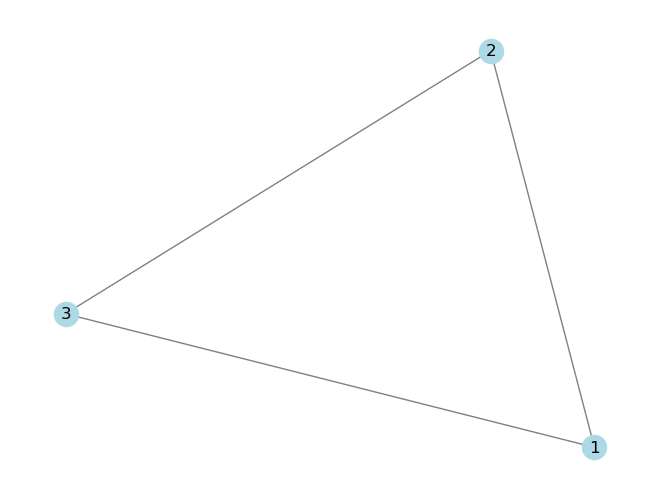

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个简单图
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 1)])

# 绘制图形
pos = nx.spring_layout(G)  # 选择布局算法
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')  # 绘制图形
plt.show()  # 显示图形

In [3]:
G = nx.path_graph(4)  # or DiGraph, MultiGraph, MultiDiGraph, etc
print(G.edges)
H = G.subgraph([0, 1, 2])
list(H.edges)

[(0, 1), (1, 2), (2, 3)]


[(0, 1), (1, 2)]

* ndata/edata 访问特征

subgraph.ndata/edata 中表明该边在原始图中的编号

In [84]:
import dgl
import torch as th

graph_data = {
   ('gene', 'gd', 'disease'): [],
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (th.tensor([0, 1, 1]), th.tensor([2, 3, 4])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
}
graph = dgl.heterograph(graph_data)
print(graph)

print("*"*10)

subgraph_nodes = {'drug': [0, 1], 'gene': [1, 3, 4], 'disease':[2]}
subgraph = graph.subgraph(subgraph_nodes)
print(subgraph)

print("********** add edges")
subgraph.add_edges(1, 0, etype=('gene', 'gd', 'disease'))
print(subgraph)

Graph(num_nodes={'disease': 3, 'drug': 3, 'gene': 5},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'interacts', 'gene'): 3, ('drug', 'treats', 'disease'): 1, ('gene', 'gd', 'disease'): 0},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), ('drug', 'disease', 'treats'), ('gene', 'disease', 'gd')])
**********
Graph(num_nodes={'disease': 1, 'drug': 2, 'gene': 3},
      num_edges={('drug', 'interacts', 'drug'): 1, ('drug', 'interacts', 'gene'): 2, ('drug', 'treats', 'disease'): 1, ('gene', 'gd', 'disease'): 0},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), ('drug', 'disease', 'treats'), ('gene', 'disease', 'gd')])
********** add edges
Graph(num_nodes={'disease': 1, 'drug': 2, 'gene': 3},
      num_edges={('drug', 'interacts', 'drug'): 1, ('drug', 'interacts', 'gene'): 2, ('drug', 'treats', 'disease'): 1, ('gene', 'gd', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), (

In [85]:
print("********** output edata")
print(subgraph.edata)

print("********** output edges")
print(subgraph.edges[('drug', 'interacts', 'drug')])

********** output edata
defaultdict(<class 'dict'>, {'_ID': {('drug', 'interacts', 'drug'): tensor([0]), ('drug', 'interacts', 'gene'): tensor([1, 2]), ('drug', 'treats', 'disease'): tensor([0]), ('gene', 'gd', 'disease'): tensor([0])}})
********** output edges
EdgeSpace(data={'_ID': tensor([0])})


In [86]:
print("********** output ndata")
print(subgraph.ndata)

print("********** output nodes")
print(subgraph.nodes[('drug')])

********** output ndata
defaultdict(<class 'dict'>, {'_ID': {'disease': tensor([2]), 'drug': tensor([0, 1]), 'gene': tensor([1, 3, 4])}})
********** output nodes
NodeSpace(data={'_ID': tensor([0, 1])})


batch

In [8]:
import dgl

# 创建两个子图
subgraph1 = dgl.graph([(0, 1), (1, 2)], num_nodes=3)
subgraph2 = dgl.graph([(0, 1), (1, 2), (2, 3)], num_nodes=4)

# 将两个子图合并成一个大图
batched_graph = dgl.batch([subgraph1, subgraph2])

# 输出合并后的大图信息
print(batched_graph)


Graph(num_nodes=7, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
{}


## for 与 else
for和else可以组成语句，如果for循环正常结束，else中语句执行。如果for是break结束的，则不执行

In [46]:
for j in range(10):
    for i in range(5):
        if j < i:
            print(j, "<", i)
            break
    else:
        print(j,i)
        continue

0 < 1
1 < 2
2 < 3
3 < 4
4 4
5 4
6 4
7 4
8 4
9 4


In [47]:
for j in range(10):
    for i in range(5):
        if j < i:
            print(j, "<", i)
            break
        else:
            print(j,i)
            continue

0 0
0 < 1
1 0
1 1
1 < 2
2 0
2 1
2 2
2 < 3
3 0
3 1
3 2
3 3
3 < 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4
8 0
8 1
8 2
8 3
8 4
9 0
9 1
9 2
9 3
9 4


# train

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

In [15]:
word2vec = np.load(r"C:\Users\69014\Desktop\代码\SGR\data\vec.npy")
print(word2vec)
print(word2vec.shape)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.38472   0.49351   0.49096  ...  0.026263  0.39052   0.52217 ]
 ...
 [ 0.40159   0.3074    0.08563  ... -0.96722   0.34538   0.027772]
 [ 0.10797   0.23429   0.32665  ... -0.8115    0.55214   0.11597 ]
 [ 0.39374  -0.28776  -0.035662 ... -0.29154  -0.45984   0.039285]]
(194784, 100)


In [17]:
from torch.utils.data import Dataset

class REDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = torch.load(data_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

dev

In [40]:
import dgl

data_path = r'C:\Users\69014\Desktop\代码\SGR\data\prepro_data\dev.pt'
# REDataset(data_path)
data = torch.load(data_path)
print(data[0])

{'subgraphs': Graph(num_nodes={'context': 110, 'entity': 258, 'mention': 306, 'sentence': 270},
      num_edges={('context', 'cc', 'context'): 110, ('context', 'ce', 'entity'): 220, ('entity', 'ec', 'context'): 220, ('entity', 'ee', 'entity'): 258, ('entity', 'em', 'mention'): 306, ('mention', 'me', 'entity'): 306, ('mention', 'mm', 'mention'): 306, ('mention', 'ms', 'sentence'): 306, ('sentence', 'sm', 'mention'): 306, ('sentence', 'ss', 'sentence'): 538},
      metagraph=[('context', 'context', 'cc'), ('context', 'entity', 'ce'), ('entity', 'context', 'ec'), ('entity', 'entity', 'ee'), ('entity', 'mention', 'em'), ('mention', 'entity', 'me'), ('mention', 'mention', 'mm'), ('mention', 'sentence', 'ms'), ('sentence', 'mention', 'sm'), ('sentence', 'sentence', 'ss')]), 'labels': tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0

In [44]:
import dgl

data_path = r'C:\Users\69014\Desktop\代码\SGR\data\prepro_data\dev.pt'
# REDataset(data_path)
data = torch.load(data_path)

num_10 = 0
num_b10 = 0
num_l10 = 0
max = -1
min = 100

print(len(data[:100]))
for i in data[:100]:
    for index, dis in enumerate(i['dis_ids']):
        if dis == 10:
            num_10+=1
            # 头尾实体之间距离为10说明 实体对中第一个提及对在上下文中是相连的
            print(i['title'], i['head_tail_entity_pairs'][index])
        elif dis > 10:
            num_b10+=1
        else:
            num_l10+=1
        if dis<min:
            min=dis
        if dis>max:
            max=dis
print("num_10", num_10)
# 大于10的和小于10的实体对数量相同是因为实体对中既有(a,b)也有(b,a)
print("num_b10", num_b10)
print("num_l10", num_l10)
print('max', max)
print('min', min)

# print(data[0])

100
IBM Research – Brazil [10, 11]
IBM Research – Brazil [11, 10]
Ned McEvoy [9, 10]
Ned McEvoy [10, 9]
Ned McEvoy [11, 12]
Ned McEvoy [12, 11]
Portland Golf Club [20, 21]
Portland Golf Club [21, 20]
Robert K. Huntington [10, 11]
Robert K. Huntington [11, 10]
Allen F. Moore [1, 2]
Allen F. Moore [2, 1]
Johan Gottlieb Gahn [6, 7]
Johan Gottlieb Gahn [7, 6]
Dollar General [14, 16]
Dollar General [16, 14]
Julian Reinard [3, 2]
Julian Reinard [2, 3]
(I Am) The Seeker [4, 5]
(I Am) The Seeker [5, 4]
(I Am) The Seeker [11, 12]
(I Am) The Seeker [12, 11]
Queen of Housewives [1, 2]
Queen of Housewives [2, 1]
Brooks Pharmacy [15, 16]
Brooks Pharmacy [16, 15]
Crouching Tiger, Hidden Dragon: Sword of Destiny [1, 2]
Crouching Tiger, Hidden Dragon: Sword of Destiny [2, 1]
Bicycles &amp; Tricycles [5, 6]
Bicycles &amp; Tricycles [6, 5]
Bicycles &amp; Tricycles [21, 22]
Bicycles &amp; Tricycles [22, 21]
Each Time You Break My Heart [8, 9]
Each Time You Break My Heart [9, 8]
Will Weng [14, 15]
Will We

# model.py

In [87]:
import torch
import torch.nn as nn

In [94]:
input_size = 1
hidden_size = 2
num_layers = 2
dropout = 0.4
lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, dropout=dropout)
for name, param in lstm.named_parameters():
    print(name)
    print(param)
    print(param.data)
    print(param.data.fill_(0))
    break

weight_ih_l0
Parameter containing:
tensor([[-0.4885],
        [-0.2515],
        [ 0.5471],
        [ 0.4903],
        [ 0.1693],
        [-0.5370],
        [-0.3068],
        [ 0.0206]], requires_grad=True)
tensor([[-0.4885],
        [-0.2515],
        [ 0.5471],
        [ 0.4903],
        [ 0.1693],
        [-0.5370],
        [-0.3068],
        [ 0.0206]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
